In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/sohee/.local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/sohee/.local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import itertools
from itertools import groupby
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [4]:
from load_data import load_data,class_breakdown

In [5]:
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [99]:
data_name = 'UWave'
full_name ="UWaveGestureLibraryAll"
#Train수가 더 적어서 파일을 바꿈
trainx, trainy = readucr('data/'+full_name+'/'+full_name+'_TEST.txt')
testx, testy = readucr('data/'+full_name+'/'+full_name+'_TRAIN.txt')
batch_size = min(int(trainx.shape[0]/10), 32)

In [7]:
print(trainx.shape)
print(testx.shape)

(3582, 945)
(896, 945)


In [8]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=437, percentage=12.200
Class=2, total=452, percentage=12.619
Class=3, total=454, percentage=12.674
Class=4, total=450, percentage=12.563
Class=5, total=433, percentage=12.088
Class=6, total=449, percentage=12.535
Class=7, total=447, percentage=12.479
Class=8, total=460, percentage=12.842
Class=1, total=122, percentage=13.616
Class=2, total=108, percentage=12.054
Class=3, total=106, percentage=11.830
Class=4, total=110, percentage=12.277
Class=5, total=127, percentage=14.174
Class=6, total=111, percentage=12.388
Class=7, total=112, percentage=12.500
Class=8, total=100, percentage=11.161


In [9]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (3582, 8)
y test shape: (896, 8)


## 데이터 정규화

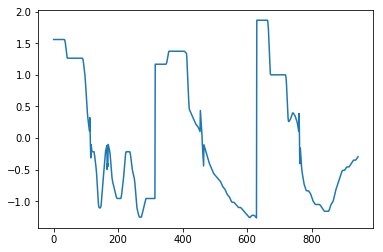

In [10]:
plt.plot(trainx[0])

In [11]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

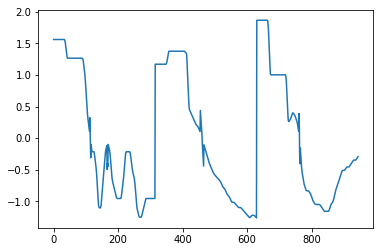

In [12]:
plt.plot(trainx[0])

In [13]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(3582, 1, 945, 1)
trainY shape:(3582, 8)
validX shape:(448, 1, 945, 1)
validY shape:(448, 8)
testX shape:(448, 1, 945, 1)
testY shape:(448, 8)


In [14]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 945
input_channel 1


# 2. Training condition 정의

In [15]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 100


std= 0.01
l_rate = 1e-5

In [16]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [17]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_last_conv_turnoff,CNN_MC_dropout_input_turnoff

In [18]:
import tensorflow as tf

In [19]:
class basic_CNN:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32,name="keep_probability")
            
            self.threshold_weight1 = tf.placeholder(tf.float32, [None, self.height, 471, 64],name="threshold_weight1")
            self.threshold_weight2 = tf.placeholder(tf.float32, [None, self.height, 234, 128],name="threshold_weight2")
            self.threshold_weight3 = tf.placeholder(tf.float32, [None, self.height, 116, 256],name="threshold_weight3")
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.prediction,1),tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 64, [1,7], padding='SAME')
            self.pooling1 = tf.layers.max_pooling2d(inputs=self.conv1, pool_size=[1, 4],padding="VALID", strides=2)
            self.batch1 = tf.layers.batch_normalization(self.pooling1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.threshold_relu1 = tf.multiply(self.relu1 , self.threshold_weight1)
            self.dropout1 = tf.nn.dropout(self.threshold_relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 128, [1,5], padding='SAME')
            self.pooling2 = tf.layers.max_pooling2d(inputs=self.conv2, pool_size=[1, 4] ,padding="VALID", strides=2)                                        
            self.batch2 = tf.layers.batch_normalization(self.pooling2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.threshold_relu2 = tf.multiply(self.relu2 , self.threshold_weight2)
            self.dropout2 = tf.nn.dropout(self.threshold_relu2, self.keep_prob)

        #Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 256, [1,3], padding='SAME')
            self.pooling3 = tf.layers.max_pooling2d(inputs=self.conv3, pool_size=[1, 4] ,padding="VALID", strides=2)   
            self.batch3 = tf.layers.batch_normalization(self.pooling3)
            self.relu3 = tf.nn.relu(self.batch3)
            self.threshold_relu3 = tf.multiply(self.relu3 , self.threshold_weight3)
            self.dropout3 = tf.nn.dropout(self.threshold_relu3, self.keep_prob)
            
        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            self.flatten = tf.reshape(self.dropout3, [-1, self.dropout3.shape[-2] * self.dropout3.shape[-1]]) 
            self.dense1 = tf.layers.dense(inputs=self.flatten,
                                     units= 256, activation=tf.nn.relu)   
            #Global Average Pooling
            #self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.dense1, self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob):
        opt, cost ,acc = self.sess.run((self.optimizer,self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.threshold_weight1: np.ones(data.shape[0]*471*64).reshape(-1,1,471,64).astype(float),
                                       self.threshold_weight2: np.ones(data.shape[0]*234*128).reshape(-1,1,234,128).astype(float),
                                       self.threshold_weight3: np.ones(data.shape[0]*116*256).reshape(-1,1,116,256).astype(float)})
        return cost,acc

    def test(self, data, target, keep_prob,threshold_weight1, threshold_weight2, threshold_weight3):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                        self.keep_prob : keep_prob,
                                        self.threshold_weight1: threshold_weight1,
                                        self.threshold_weight2: threshold_weight2,
                                        self.threshold_weight3: threshold_weight3})
        return cost,acc

    def get_conv_output(self, conv_output,data, keep_prob,threshold_weight1, threshold_weight2, threshold_weight3):
        conv_output =  self.sess.run((conv_output), 
                                     feed_dict={self.x: data,self.keep_prob: keep_prob,
                                                self.threshold_weight1: threshold_weight1,
                                                self.threshold_weight2: threshold_weight2,
                                                self.threshold_weight3: threshold_weight3})
        return conv_output
    
    def predict(self, data, keep_prob,threshold_weight1, threshold_weight2, threshold_weight3):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,self.keep_prob: keep_prob,
                                        self.threshold_weight1: threshold_weight1,
                                        self.threshold_weight2: threshold_weight2,
                                        self.threshold_weight3: threshold_weight3})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

In [20]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

8


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [21]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
#MC_dropout_model =CNN_MC_dropout_input_turnoff(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

MC_dropout_model =basic_CNN(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

#MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
#                                 std=std,batch_size=batch_size,l_rate=l_rate)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


In [22]:
print (MC_dropout_model.input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pooling1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pooling2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3] - MC dropout')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pooling3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)
print (MC_dropout_model.dropout3)

print ('[layer4]')
print (MC_dropout_model.flatten)
print (MC_dropout_model.dense1)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 945, 1), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 945, 64), dtype=float32)
Tensor("layer1/max_pooling2d/MaxPool:0", shape=(?, 1, 471, 64), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 471, 64), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 471, 64), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 471, 64), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 471, 128), dtype=float32)
Tensor("layer2/max_pooling2d/MaxPool:0", shape=(?, 1, 234, 128), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 234, 128), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 234, 128), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 234, 128), dtype=float32)
[layer3] - MC dropout
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 234, 256), dtype=float32)
Tensor("layer3/max_pooling2d/MaxPool:0", s

# 4. Training

In [23]:
import time
import os
import numpy as np

In [24]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_basic_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

UWave_CNN_MCdropout_basic_1e-05_32


In [25]:
from training import get_batch

In [26]:
keep_prob =1.0

In [27]:
# for epoch in range(num_epochs):#range(num_epochs):##
    
#     loss = 0
#     acc=0
#     train_batches = 0
#     start_time = time.time()   
    
#     for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
#         train_in, train_target = batch
#         train_batches += 1.0 
#         loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob)
#         loss = loss1+loss
#         acc = acc1+acc
#         if np.isnan(loss):
#             print ('error')
#             break
#     t_loss.append(loss/train_batches)
#     t_acc.append(acc/train_batches)
    
#     train_history.loc[epoch] = [epoch, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
#     if not os.path.exists(os.path.join(save_path, model_name)):
#         os.mkdir( os.path.join(save_path, model_name))
#     MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
#     if(epoch+1)%val_freq ==0:
#         acc=0
#         loss = 0
#         val_batches=0
#         for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
#             val_in, val_target = batch
#             val_batches += 1.0 
#             loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,
#                                             threshold_weight1 = np.ones(val_in.shape[0]*471*64).reshape(-1,1,471,64).astype(float),
#                                             threshold_weight2 = np.ones(val_in.shape[0]*234*128).reshape(-1,1,234,128).astype(float),
#                                             threshold_weight3 = np.ones(val_in.shape[0]*116*256).reshape(-1,1,116,256).astype(float)  )
#             loss = loss1+loss
#             acc = acc1+acc
        
#         v_acc.append(acc/val_batches)
#         v_loss.append(loss/val_batches)
#         valid_history.loc[epoch] = [epoch, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
#         print("  training loss:\t{:.6f}".format(t_loss[epoch]))
#         print("  training acc:\t{:.3f}".format(t_acc[epoch]))
#         print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
#         print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


In [28]:
# train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
# valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [29]:
from visualization import plot_train_history

In [30]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/UWave/UWave_CNN_MCdropout_basic_1e-05_32/loss_graph.png
save ./model/UWave/UWave_CNN_MCdropout_basic_1e-05_32/acc_graph.png


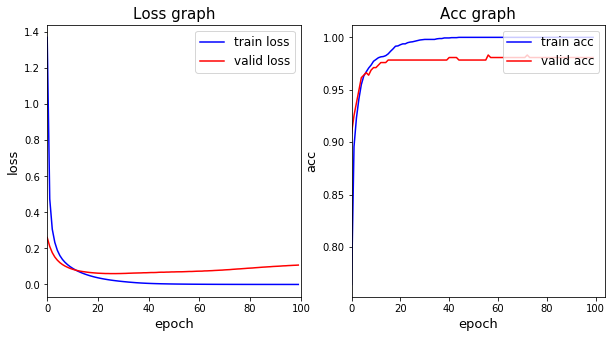

In [31]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [32]:
bestepoch = int(np.argmin(valid_history['loss'].values))
print( bestepoch)

25


In [33]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.060215130054320276


In [34]:
MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/UWave/UWave_CNN_MCdropout_basic_1e-05_32/25.ckpt
Model restored


In [35]:
import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+".*")):
        os.remove(filename) 

### with confusion matrix

In [36]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [37]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

In [38]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,
                                      threshold_weight1 = np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                      threshold_weight2 = np.ones(trainX.shape[0]*6*128).reshape(-1,1,6,128).astype(float))
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

TypeError: predict() missing 1 required positional argument: 'threshold_weight3'

In [ ]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,
                                      threshold_weight1 = np.ones(testX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                      threshold_weight2 = np.ones(testX.shape[0]*6*128).reshape(-1,1,6,128).astype(float))
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
acc를 ~이상 떨어지게 하는 threshold

In [ ]:
import random

In [ ]:
original_cost , original_acc = MC_dropout_model.test(trainX,trainY,1.0,
                                      threshold_weight1 = np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                      threshold_weight2 = np.ones(trainX.shape[0]*6*128).reshape(-1,1,6,128).astype(float))

In [ ]:
conv_output1,conv_output2 = MC_dropout_model.get_conv_output(conv_output = (MC_dropout_model.relu1,MC_dropout_model.relu2),
                                                data=trainX,keep_prob=1.0,
                                                threshold_weight1 = np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                                 threshold_weight2 = np.ones(trainX.shape[0]*6*128).reshape(-1,1,6,128).astype(float))


## pattern 추출

In [85]:
import math

###### conv1
conv_filter1 = 7
conv_pad1 = int((conv_filter1 -1) /2)

pool_size1 = 4 
pool_pad1 = 0
pool_stride1 = 2
input_width = 117

featuermap1 = math.floor( (input_width+(2*pool_pad1)-pool_size1)/pool_stride1 + 1 )


###### conv2
conv_filter2 = 5
conv_pad2 = int((conv_filter2 -1) /2)

pool_size2 = 4 
pool_pad2 = 0
pool_stride2 = 2

featuermap2 = math.floor( (featuermap1+(2*pool_pad2)-pool_size2)/pool_stride2 + 1 )


#######################
# receptive filed conv2 
(conv_filter1+pool_size1-1)+(pool_stride1+pool_stride2)*pool_size2

#start point
0-conv_pad1-pool_size2

#jump
pool_stride1*pool_stride2

4

In [86]:
(conv_filter1+pool_size1-1)+(pool_stride1+pool_stride2)*pool_size2

26

In [87]:
0-conv_pad1-pool_size2

-7

In [90]:
conv_pad2

2

In [63]:
conv_filter3 = 3
conv_pad3 = int((conv_filter3 -1) /2)

pool_size3 = 3
pool_pad3 = 0
pool_stride3 = 3

featuermap3 = math.floor( (featuermap2+(2*pool_pad3)-pool_size3)/pool_stride3 + 1 )

1
4


In [74]:
# receptive filed conv2 
print((conv_filter1+pool_size1-1)+(pool_stride1+pool_stride2)*pool_size2)

#start point
print(-conv_pad1-pool_stride1)

#jump
print(pool_stride1*pool_stride2)

31
-6
6


In [73]:
# receptive filed conv3
print((conv_filter1+pool_size1-1)+(pool_stride1+pool_stride2)*pool_size2 +(pool_stride1+pool_stride2+pool_stride3)*pool_size3)

#start point
print(0-conv_pad1-pool_size2-pool_size3)

#jump
print(pool_stride1*pool_stride2*3)

55
-10
18


In [53]:
conv_filter1+pool_size1-1

11

In [ ]:
import random
random.seed(1003)
random_sample_idx = random.sample(range(0,len(trainX)), len(trainX)//900-1)

In [ ]:
len(random_sample_idx)

In [ ]:
RF1 = []
RF1_id = 0

RF2 = []
RF2_id = 0

for data_idx,data in zip(random_sample_idx,trainX[random_sample_idx,0,:,:]):
    for fm_idx in range(featuermap1):
        for input_channel in range(trainX.shape[-1]):
            start_point = (fm_idx * pool_stride1) - conv_pad1
            end_point = start_point + (conv_filter1-1) + (pool_size1 - 1)
            
            if start_point < 1 : # zero padding 앞부분
                zero_x = [i for i in range(start_point, 0)]
                rest_x = list(range(1,end_point+2))
                pattern_xs = zero_x + rest_x
                
                zero_y = [0 for i in range(start_point, 0)]
                rest_y = list(data[rest_x, input_channel])
                pattern_ys = zero_y + rest_y
            
            elif end_point >= input_width : # zero padding 뒷부분
                rest_x = list(range(start_point ,117))
                zero_x = [i for i in range(117, end_point+1)]
                pattern_xs = rest_x + zero_x
                
                rest_y = list(data[rest_x,input_channel])
                zero_y = [0 for i in range(117, end_point+1)]
                pattern_ys = rest_y + zero_y              
                
            else :
                pattern_xs = list(range(start_point,end_point+1))
                pattern_ys = list(data[pattern_xs, input_channel])   
            RF1.append({'RF1_id':RF1_id,'data_idx':data_idx, 'input_channel':input_channel,'featuremap_idx':fm_idx,
                         'pattern_xs':pattern_xs, 'pattern_ys':pattern_ys})   
            RF1_id += 1
            
    for fm_idx in range(featuermap2):
        for input_channel in range(trainX.shape[-1]):
            start_idx = (fm_idx * pool_stride2) - conv_pad2 
            end_idx = start_idx + (conv_filter2 -1) + (pool_size2 -1)
            if start_idx < 1 : # zero padding 앞부분
                end_point = [x['pattern_xs'][-1] for i,x in enumerate(RF1) if x['featuremap_idx'] == end_idx][0]
                
                zero_x = [i for i in range(start_idx * pool_stride2  -4, 0)]
                rest_x = list(range(1,end_point+1))
                pattern_xs = zero_x + rest_x
                
                zero_y = [0 for i in range(start_idx * pool_stride2 -4, 0)]
                rest_y = list(data[rest_x, input_channel])
                pattern_ys = zero_y + rest_y
            
            elif end_idx > featuermap1 : # zero padding 뒷부분 // 다시 짜야함
                
                start_point = [x['pattern_xs'][0] for i,x in enumerate(RF1) if x['featuremap_idx'] == start_idx][0]
        
                rest_x = list(range(start_point ,28))
                zero_x = [i for i in range(28 , end_point+1)]
                pattern_xs = rest_x + zero_x
                
                rest_y = list(data[rest_x,input_channel])
                zero_y = [0 for i in range(28, end_point* pool_stride2  -4)]
                pattern_ys = rest_y + zero_y            
            
            else : 
                start_point = [x['pattern_xs'][0] for i,x in enumerate(RF1) if x['featuremap_idx'] == start_idx][0]
                end_point = [x['pattern_xs'][-1] for i,x in enumerate(RF1) if x['featuremap_idx'] == end_idx][0]
                pattern_xs = list(range(start_point,end_point+1))
                pattern_ys = data[pattern_xs,input_channel]
                
            RF2.append({'RF2_id':RF2_id,'data_idx':data_idx, 'input_channel':input_channel,'featuremap_idx':fm_idx,
                         'pattern_xs':pattern_xs, 'pattern_ys':pattern_ys})   
            RF2_id += 1                         

### weigthed k means

https://www.kaggle.com/andyxie/k-means-clustering-implementation-in-python
https://brunch.co.kr/@rlawlgy43/32

In [ ]:
weight = []
data = []
for idx in random_sample_idx:
    weight.append([np.repeat(conv_output2[idx,0,:,0],(45)).reshape(6,45) for i in range(128)])
    data.append(np.tile([x['pattern_ys'] for x in RF2 if (x['data_idx']==idx) & (x['input_channel']==0)],(128,1,1)))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np

colors = 10*["g","r","c","b","k"]

class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [ ]:
clf = K_Means(k=5)
clf.fit(data)

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
        
plt.show()

In [ ]:
data = np.reshape(data,(-1,45))

In [ ]:
data.shape

In [ ]:
k = 3
# Number of training data
n = data.shape[0]
# Number of features in the data
c = data.shape[1]

# Generate random centers, here we use sigma and mean to ensure it represent the whole data
mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
centers = np.random.randn(k,c)*std + mean

# Plot the data and the centers generated as random
colors=['orange', 'blue', 'green']
for i in range(n):
    plt.scatter(data[i, 0], data[i,1], s=7)
plt.scatter(centers[:,0], centers[:,1], marker='*', c='g', s=150)

In [ ]:
distances.shape

In [ ]:
from copy import deepcopy
centers_old = np.zeros(centers.shape) # to store old centers
centers_new = deepcopy(centers) # Store new centers

data.shape
clusters = np.zeros(n)
distances = np.zeros((n,k))

error = np.linalg.norm(centers_new - centers_old)

# When, after an update, the estimate of that center stays the same, exit loop
while error != 0:
    # Measure the distance to every center
    for d in range(n):
        for i in range(k):
            distances[d,i] = np.linalg.norm(data[d] - centers[i])
#     # Assign all training data to closest center
#     clusters = np.argmin(distances, axis = 1)
    
#     centers_old = deepcopy(centers_new)
#     # Calculate mean for every cluster and update the center
#     for i in range(k):
#         centers_new[i] = np.mean(data[clusters == i], axis=0)
#     error = np.linalg.norm(centers_new - centers_old)
# centers_new 

In [ ]:
centers_new.shape

In [ ]:
# Plot the data and the centers generated as random
colors=['orange', 'blue', 'green']
for i in range(n):
    plt.scatter(data[i, 0], data[i,1], s=7)
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)

In [ ]:
np.array(data).shape

In [ ]:
best_cluster_n = 20

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

random.seed(300)

default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}

g_cluster_pattern_list = []
k_cluster_pattern_list = []

gmm_option = [
    ({'n_clusters': best_cluster_n})
]

kmeans_option = [
    ({'n_clusters': best_cluster_n})
]

for g_option,k_option in zip(gmm_option,kmeans_option):
    g_params = default_gmm.copy()
    g_params.update(g_option)

    k_params = default_kmeans.copy()
    k_params.update(k_option)

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])

    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(data)
    k_pred = kmeans.fit_predict(data)

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,6))
    axes = fig.subplots(2, g_params['n_clusters'])

    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        
        g_class_pattern = np.array([data[idx] for idx in g_class_idx])
        k_class_pattern = np.array([data[idx] for idx in k_class_idx])

        g_cluster_mean = g_class_pattern.mean(axis=0)
        k_cluster_mean = k_class_pattern.mean(axis=0)

        # visualization
        axes[0,class_].plot(g_class_pattern.T, color =color[class_],alpha=0.6)
        axes[1,class_].plot(k_class_pattern.T, color =color[class_],alpha=0.6)

        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)
        
#         # append list
#         g_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":g_cluster_mean} for idx in g_class_idx])
#         k_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":k_cluster_mean} for idx in k_class_idx])
 

    #("KMeans: {} \nGMM: {}".format(k_params,g_params),y=1.5)
    plt.tight_layout()
    plt.show()

In [ ]:
np.array(data).shape

In [ ]:
weight = np.reshape(weight,(-1))
data = np.reshape(data,(-1,45))

In [ ]:
KMeans(n_clusters=10, random_state=0).fit_predict(data, sample_weight=weight)

In [ ]:
>>> from sklearn.cluster import KMeans
>>> import numpy as np
>>> X = np.array([[1, 2], [1, 4], [1, 0],
...               [10, 2], [10, 4], [10, 0]])
>>> kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
>>> kmeans.labels_
array([1, 1, 1, 0, 0, 0], dtype=int32)
>>> kmeans.predict([[0, 0], [12, 3]])
array([1, 0], dtype=int32)
>>> kmeans.cluster_centers_
array([[10.,  2.],
       [ 1.,  2.]])

In [ ]:
conv_output2[0,0,:,[1]].T.shape

In [ ]:
A=original_acc*0.2

turnoff_acc_list=[original_acc]
turnoff_cost_list=[original_cost]
threshold = 0
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)

find_threshold = False
for T in range(990, 650, -5):
    
    temp_threshold1 = 0#np.percentile(conv_output1,T/10.0,[0,1,2])
    temp_threshold2 = np.percentile(conv_output2,T/10.0,[0,1,2])
    
    
    temp_conv_bool1 = conv_output1>temp_threshold1
    temp_conv_bool2 = conv_output2>temp_threshold2
    
    
    threshold_weight1 = (~temp_conv_bool1).reshape(-1,1,28,64)
    threshold_weight2 = (~temp_conv_bool2).reshape(-1,1,6,128)
    
    turnoff_cost , turnoff_acc = MC_dropout_model.test(trainX,trainY,1.0,
                                    threshold_weight1 = threshold_weight1.astype(float),
                                    threshold_weight2 = threshold_weight2.astype(float))
    
    #print ("[top {}% , threshold: {}]\noriginal acc:{}, turnoff_acc{}".format(100- T/10.0,threshold,original_acc,turnoff_acc))
    turnoff_acc_list.append(turnoff_acc)
    turnoff_cost_list.append(turnoff_cost)
    acc_difference = original_acc - turnoff_acc
    
    if ((acc_difference > A)&(find_threshold==False)):
        find_threshold = 100-(T/10.0)
        threshold1 = temp_threshold1
        threshold2 = temp_threshold2

        conv_bool1 = temp_conv_bool1
        conv_bool2 = temp_conv_bool2
        ax.scatter(100-(T/10.0),turnoff_acc,s=40,c='darkcyan')

ax.scatter(0,original_acc,c='darkcyan',s=40)
ax.plot([100- (x/10.0) for x in range(995+5, 650, -5)][:-1], turnoff_acc_list ,c='black',label="turnoff_acc")
ax.axhline(original_acc, c='darkcyan',label="original_acc")
ax.legend()

ax.set_xlabel("TOP - %")
ax.set_ylabel("ACCURACY ")

ax.set_xlim(0,100- (T/10.0))
fig.suptitle("ACCURACY WHEN TURN OFF TOP -% NODE IN UNIT ")

In [ ]:
temp_conv_bool2[random_sample_idx].shape

In [ ]:
import Pycluster as pc

In [ ]:
import 

In [ ]:
conv_output2.shape

In [ ]:
# Save as npy
np.save('consecutive_pattern{}.npy'.format(len(trainX)//3), consecutive_pattern)

In [ ]:
len(consecutive_pattern)

In [ ]:
consecutive_pattern = np.load('./consecutive_pattern_randomsample(0.2).npy',allow_pickle=True)

In [ ]:
os.path.join(save_path,model_name,"consecutive_pattern_randomsample(0.2).npy")

In [ ]:
len(consecutive_pattern)

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform([x['pattern_ys'] for x in consecutive_pattern])
normalized_pattern_candidate = np.asarray(normalized_pattern_candidate).squeeze()

## pattern clustering

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import cluster, mixture

pseudoF_gmm = []
pseudoF_kmeans = []


cut_num=20

fig = plt.figure(figsize=(20,5))
for n_clusters in range(3,cut_num):
    gmm = mixture.GaussianMixture(n_components=n_clusters, 
            covariance_type='full')
    labels = gmm.fit_predict(normalized_pattern_candidate)
    pseudoF_gmm.append(metrics.calinski_harabasz_score(normalized_pattern_candidate, labels))
    
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    
    labels = kmeans.fit_predict(normalized_pattern_candidate)
    pseudoF_kmeans.append(metrics.calinski_harabasz_score(normalized_pattern_candidate, labels))

x = np.arange(3,cut_num)
ax = plt.subplot(1,2,1)
ax.plot(x, pseudoF_gmm[:cut_num])
ax.set_xticks(x)
ax.set_title("GMM pseudoF score")
plt.grid()

ax = plt.subplot(1,2,2)
ax.plot(x, pseudoF_kmeans[:cut_num])
ax.set_xticks(x)
ax.set_title("Kmeans pseudoF score")
plt.grid()

plt.show()

In [ ]:
best_cluster_n = 9

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

random.seed(300)

default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}

In [ ]:
best_cluster_n = 9

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

random.seed(300)

default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}

g_cluster_pattern_list = []
k_cluster_pattern_list = []

gmm_option = [
    ({'n_clusters': best_cluster_n})
]

kmeans_option = [
    ({'n_clusters': best_cluster_n})
]

for g_option,k_option in zip(gmm_option,kmeans_option):
    g_params = default_gmm.copy()
    g_params.update(g_option)

    k_params = default_kmeans.copy()
    k_params.update(k_option)

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])

    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,6))
    axes = fig.subplots(2, g_params['n_clusters'])

    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        
        g_class_pattern = np.array([normalized_pattern_candidate[idx] for idx in g_class_idx])
        k_class_pattern = np.array([normalized_pattern_candidate[idx] for idx in k_class_idx])

        g_cluster_mean = g_class_pattern.mean(axis=0)
        k_cluster_mean = k_class_pattern.mean(axis=0)

        # visualization
        axes[0,class_].plot(g_class_pattern.T, color =color[class_],alpha=0.6)
        axes[1,class_].plot(k_class_pattern.T, color =color[class_],alpha=0.6)

        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)
        
        # append list
        g_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":g_cluster_mean} for idx in g_class_idx])
        k_cluster_pattern_list.extend([{"class":class_,"pattern_id":idx,"pattern_ys":normalized_pattern_candidate[idx],"pattern_mean":k_cluster_mean} for idx in k_class_idx])
 

    #("KMeans: {} \nGMM: {}".format(k_params,g_params),y=1.5)
    plt.tight_layout()
    plt.show()

In [ ]:
g_class_pattern[random.sample(range())]

### remove outlier pattern for better clustering

다음 알고리즘을 짜기위해 우선 건너뜀

각 conv2 ouput channel 마다 cluster label 모으기

In [ ]:
from collections import Counter

In [ ]:
for i,x in enumerate(consecutive_pattern):
    x["pattern_label"] = g_pred[i]

In [ ]:
for output_channel in range(128):
    vars()["output_pattern"+str(output_channel+1)] = [x['pattern_label'] for x in consecutive_pattern if output_channel in x['output_channel']]
    vars()["output_pattern_dict"+str(output_channel+1)] = Counter(eval("output_pattern"+str(output_channel+1)))

In [ ]:
pattern_frequency_arr = np.zeros(best_cluster_n* 128).reshape(best_cluster_n,128)

In [ ]:
for output_channel in range(128):
    for cluster in range(best_cluster_n):
        pattern_frequency_arr[cluster][output_channel]=eval("output_pattern_dict"+str(output_channel+1))[cluster]

In [ ]:
pattern_frequency_arr= pattern_frequency_arr.astype(int)

In [ ]:
import seaborn as sns 

In [ ]:
plt.imshow(pattern_frequency_arr.T,aspect="auto",cmap="OrRd")

In [ ]:
pattern_frequency_arr.shape

In [ ]:
patt

In [ ]:
np.quantile(pattern_frequency_arr,0.75,0).shape

In [ ]:
#conv2_bool = (pattern_frequency_arr>np.quantile(pattern_frequency_arr,0.75,0)).T



In [ ]:
plt.imshow(conv2_bool,aspect="auto",cmap="OrRd")

# unit별 IOU계산

In [ ]:
def conv_IOU(convbool,convbool_list):
    IOU= [(x==convbool).sum()/len(convbool) for x in convbool_list]
    return IOU

In [ ]:
conv2_IOU = np.zeros(conv_output2.shape[3]*conv_output2.shape[3]).reshape(conv_output2.shape[3],conv_output2.shape[3])

In [ ]:
conv2_bool.shape

In [ ]:
for conv_c1 in range(conv_output2.shape[3]):
    conv2_IOU[conv_c1][:]= conv_IOU(conv2_bool[conv_c1,:],
                                    conv2_bool)

In [ ]:
f = plt.figure(figsize=(15,15))
ax = plt.subplot(1,1,1)
sns.heatmap(conv2_IOU, ax = ax, cmap ="OrRd", linewidths = 0.1) 
ax.set_title("IOU scores for CONV2")

#ax2 = plt.subplot(1,2,2)
#sns.heatmap(1.0 - conv2_IOU, ax = ax2, cmap ="OrRd", linewidths = 0.1) 
#ax2.set_title("DISTANCE(1-IOU) scores for CONV2")

In [ ]:
import copy

In [ ]:
find_same_bool = -np.ones(128).astype(int)

In [ ]:
t=0
while (find_same_bool >-1).sum()<128:
    find_same_bool[[i for i,x in enumerate(conv2_IOU[t]) if x==1.0 ]]=t
    t+=1

In [ ]:
np.unique(find_same_bool)

In [ ]:
unit_cluster_num = len(np.unique(find_same_bool))

In [ ]:
fig = plt.figure(figsize=(5,unit_cluster_num))
for i, same_idx in enumerate(np.unique(find_same_bool)):
    ax = plt.subplot(unit_cluster_num,1,i+1)
    ax.imshow(conv2_bool[same_idx].reshape(1,-1).astype(int),aspect="auto",cmap="OrRd",vmin=0, vmax=1)
    ax.set_title("UNIT-CLSUTER{}, \n# of unit in cluster:{}".format((i+1), Counter(find_same_bool)[same_idx]))
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
cg = sns.clustermap(conv1_IOU, cmap ="OrRd",
                    linewidths = 0.1, robust=True,
                   metric ="correlation"); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 

Z= cg.dendrogram_col.linkage

from scipy.cluster.hierarchy import fcluster
max_d = 1
clusters = fcluster(Z, max_d, criterion='distance')
clusters

k=50
clusters =fcluster(Z, k, criterion='inconsistent')

clusters

for idx in [i for i,x in enumerate(clusters) if x==8]:
    plt.imshow(conv2_bool[idx].T.reshape(1,-1),aspect="auto", cmap ="OrRd")
    plt.show()

## turn off unit

In [ ]:
true_bool=np.ones(trainX.shape[0]*6*128).reshape(-1,1,6,128)
false_bool = np.zeros(trainX.shape[0]*6*128).reshape(-1,1,6,128)

In [ ]:
MC_dropout_model.relu2.shape

In [ ]:
plt.imshow(unit_bool[0].squeeze())

In [ ]:
np.unique(find_same_bool)[0]

In [ ]:
each_clustering_turnoff=[original_acc]
for same_idx in np.unique(find_same_bool):
    unit_bool =copy.deepcopy(true_bool)
    for idx in [i for i,x in enumerate(find_same_bool) if x==same_idx]:
        unit_bool[:,:,:,idx] = False
    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.threshold_weight1 :np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                    MC_dropout_model.threshold_weight2 :unit_bool})
    each_clustering_turnoff.append(acc)
    
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1,)
ax.scatter(0,original_acc,c='r',s=40)
ax.set_xticks(np.arange(0,unit_cluster_num+1))
ax.plot(each_clustering_turnoff,c='black')
ax.axhline(original_acc, c='r')
ax.set_xlabel("UNIT CLUSTERING ID")
ax.set_ylabel("ACCURACY")
plt.grid()
fig.suptitle("ACCURACY WHEN UNIT-CLUSTRING IS TURNED OFF ")

In [ ]:
same_idx = np.unique(find_same_bool)[5]
unit_bool =copy.deepcopy(true_bool)
for idx in [i for i,x in enumerate(find_same_bool) if x==same_idx]:
    unit_bool[:,:,:,idx] = False
acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                      feed_dict={MC_dropout_model.x: trainX,
                                 MC_dropout_model.y: trainY,
                                MC_dropout_model.keep_prob:1.0,
                                MC_dropout_model.threshold_weight1 :np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                MC_dropout_model.threshold_weight2 :unit_bool})

In [ ]:
each_clustering_turnon=[original_acc]
for same_idx in np.unique(find_same_bool):
    unit_bool =copy.deepcopy(false_bool)
    for idx in [i for i,x in enumerate(find_same_bool) if x==same_idx]:
        unit_bool[:,:,:,idx] = True
    acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.threshold_weight1 :np.ones(trainX.shape[0]*28*64).reshape(-1,1,28,64).astype(float),
                                    MC_dropout_model.threshold_weight2 :unit_bool})
    each_clustering_turnon.append(acc)
    
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1,)
ax.scatter(0,original_acc,c='r',s=40)
ax.set_xticks(np.arange(0,unit_cluster_num+1))
ax.plot(each_clustering_turnon,c='black')
ax.axhline(original_acc, c='r')
ax.set_xlabel("UNIT CLUSTERING ID")
ax.set_ylabel("ACCURACY")
plt.grid()
fig.suptitle("ACCURACY WHEN UNIT-CLUSTRING IS TURNED ON ")

# clustering

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
n_clusters = 6

# clustering with fixed length data

1. 패턴의 길이를 fix하고 해당 length의 패턴만을 클러스터링

In [ ]:
pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if len(x['pattern_idx']) ==pattern_len]
specific_pattern=[x['pattern'] for i,x in enumerate(consecutive_pattern) if i in specific_len_pattern_idx]
len(specific_len_pattern_idx)

## pattern standardization
1. 평균0, 분산1 형태로 standardization

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(specific_pattern)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

## spectral clustering, gmm clustering,k-means,SOM

In [ ]:
from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "rbf"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 6})
    
]

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

In [ ]:
random.seed(300)
for g_option,k_option in zip(gmm_option,kmeans_option):

    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    
    g_cluster_mean_pattern =[]
    k_cluster_mean_pattern =[]

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,7))
    axes = fig.subplots(2, g_params['n_clusters'])
    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]

        try:
            axes[0,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)

        except:
            axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)

        g_cluster_mean = normalized_pattern_candidate[g_class_idx].mean(axis=0)
        g_cluster_mean_pattern.append(g_cluster_mean)
        k_cluster_mean = normalized_pattern_candidate[k_class_idx].mean(axis=0)
        k_cluster_mean_pattern.append(k_cluster_mean)
        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)

    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

In [ ]:
import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False,threshold_weight = np.ones(trainX.shape[0]*128*128).reshape(-1,1,128,128))

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx= list(set(specific_data_pattern_idx) & set(specific_len_pattern_idx))
    specific_pattern_info = [consecutive_pattern[x] for x in specific_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==15:
        break
    
    for p_idx,p_info in zip(specific_pattern_idx, specific_pattern_info):
        plot_idx+=1
        # 데이터 자체 그리기
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        data = trainX[d_idx,0,:,input_pattern_channel]
        ax.plot(data,color='black')
        
        highlight_bool = np.zeros(width).astype(bool)
        for p_channel in p_info['pattern_channel']:
            hightlight_bool = (highlight_bool | last_conv_bool[d_idx,:,p_channel])
        
        
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(hightlight_bool) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)

        color_idx = g_pred[specific_len_pattern_idx.index(p_idx)]
        pattern_idx = p_info['pattern_idx']
        ax.plot(pattern_idx, data[pattern_idx], color = color[color_idx])

        # 패턴의 평균값 굵고 투명하게 그리기
        x = g_cluster_mean_pattern[color_idx].reshape(-1,1) #returns a numpy array
        min_max_scaler = MinMaxScaler(feature_range=(data[pattern_idx].min(), data[pattern_idx].max()))
        pattern_scaled = min_max_scaler.fit_transform(x)
        ax.plot(pattern_idx, pattern_scaled, color = color[color_idx], alpha=0.4,linewidth=10)
        fig.suptitle("data{} : label{}, prediction{} \n in last conv output_channel{}".format(d_idx, np.argmax(trainY[d_idx]),np.argmax(prediction[d_idx]),p_info['pattern_channel']),y=1.0)
    plt.show()
    

## clustering with different length scale

#### Global Alignmnet Kernel K Means

In [ ]:
pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern)]
specific_pattern=[x['pattern'] for i,x in enumerate(consecutive_pattern) if i in specific_len_pattern_idx]
len(specific_len_pattern_idx)

In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import GlobalAlignmentKernelKMeans

In [ ]:
#길이를 맞추기위해 nan으로 패딩
X =to_time_series_dataset(specific_pattern)

In [ ]:
gak_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters)
gak_km_predict = gak_km.fit_predict(X)

class_breakdown(gak_km_predict)

In [ ]:
for n in range(n_clusters):
    idx = [i for i,x in enumerate(gak_km_predict) if x==n]
    vars()["pattern_"+str(n)] = [pattern[i] for i in idx ]

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    for p in eval("pattern_"+str(n)):
        ax.plot(range(len(p)),p,color = color[n])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    mindexes = [np.argmax(x) for x in eval("pattern_"+str(n))]
    vars()["norm_pattern_"+str(n)] = [(x-min(x)) for x in eval("pattern_"+str(n))]
    for i,p in enumerate(eval("norm_pattern_"+str(n))):
        shifts = max(mindexes) - mindexes[i]
        ax.plot(range(shifts,shifts+len(p)), p,color=color[n],alpha=0.2)

plt.show()

### find representative shape for each clustering

#### 1. Using U shapelet
ref: Clustering Time Series using Unsupervised-Shapelets

In [ ]:
len(pattern)

In [ ]:
import copy
sLen = range(5,9)
D=copy.deepcopy(pattern)

In [ ]:
S_hat=[]
ts=D[50]
for _ in range(10):
    cnt=0 #count of candidate u-shapelets from ts
    s_hat ={} #set of subsequences, initially empty
    gap = []
    dt =[]
        
    for sl in sLen:#each u-shapelet length
        for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
            s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
            tup = compute_gap(s_hat[cnt],D,6)
            gap.append(tup[0])
            dt.append(tup[1])
            cnt+=1
    if cnt>0:
        index1 = np.argmax(gap)
        S_hat.append(s_hat[index1]) #find maximum gap score
        dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
        try:
            dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True] #points to the left of dt
        except:
            dA = [dis[i] for i,x in enumerate(dis) if x<dt[0]]

        if len(dA) ==1:
            print("dA length:1")
            break
        else:
            index2 = np.argmax(dis)
            ts = D[index2]
            msdA= np.mean(dA) +np.std(dA)
            D_hat = [i for i,x in enumerate(dis<msdA) if x ==True]
            idx = [x for x in np.arange(0,len(D)) if x not in D_hat]
            new_D=[]
            for d_idx in idx:
                new_D.append(D[d_idx])
            D=new_D

In [ ]:
def znorm(data):
    return (data-min(data))/(max(data)-min(data))

In [ ]:
def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

In [ ]:
def compute_gap(sub, data,cluster_num):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1):
        d = (dis[l]+dis[l+1])/2

        dA = dis[dis<d]
        dB = dis[dis>d]
        try:
            r = len(dA)/len(dB)
            if ((1/cluster_num < r) and (1-(1/cluster_num))):
                mA = dA.mean()
                mB = dB.mean()
                sA = dA.std()
                sB = dB.std()
                gap = mB-sB-(mA+sA)
                if gap > maxGap :
                    #print("gap {}".format(gap))
                    maxGap =gap
                    dt =d
        except:
            pass
    return maxGap, dt

In [ ]:
def compute_distance(sub, data):
    dis=[10e3]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]

        for j in range(0, len(ts)-len(sub)):
            z = znorm(ts[j:j+len(sub)])
            d = euclidean_d(z,sub)
            dis[i]= min(d,dis[i])/np.sqrt(len(sub))
        #print(dis[i])
    return dis

#### 2. Use dtw measure

In [ ]:
from dtwalign import dtw

In [ ]:
x = norm_pattern_5[60]
y = norm_pattern_5[0]
res = dtw(x,y)

# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

"""
if you want to calculate only dtw distance (i.e. no need to gain alignment path),
give 'distance_only' argument as True (it makes faster).
"""
#res = dtw(x,y,distance_only=True)

In [ ]:

ax = plt.subplot(2,1,1)
ax.plot(x,color="blue")
ax.plot(y,color="red")
ax.set_ylim(0,1)
# warp both x and y by alignment path
x_path = res.path[:,0]
y_path = res.path[:,1]

ax = plt.subplot(2,1,2)
ax.plot(x[x_path],label="aligned query",color="blue")
ax.plot(y[y_path],label="aligned reference",color="red")
ax.legend()
ax.set_ylim(0,1)

# visualize alignment path with cumsum cost matrix
res.plot_path()

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_info = [consecutive_pattern[x] for x in specific_data_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==5:
        break
    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']== p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_data_pattern_idx[idx]
            color_idx = gak_km_predict[specific_data_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
        break

        
    plt.show()

# Below part is still unclear

f = open('file.txt', 'a+t')
for i,x in enumerate(X):
    for x_ in x:
        f.write(str(x_[0])+",")
    f.write(":"+str(gak_km_predict[i])+"\n")

f.close()      

In [ ]:
X_df = pd.DataFrame(columns=["dim_0"],index=range(len(X)))
for i,x in enumerate(X):
    X_df.iloc[i,0] = x

In [ ]:
Y_df =gak_km_predict.astype('<U1')

In [ ]:
from sktime.transformers.shapelets import ContractedShapeletTransform
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(X_df, Y_df)

In [ ]:
# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(
        X[s.series_id],
        'gray'
    )

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        X[s.series_id,s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

## hierarchical clustering

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

In [ ]:
import matplotlib.patheffects as pe

In [ ]:
random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

# SOM

In [ ]:
import sompy

In [ ]:
som = sompy.SOMFactory.build(normalized_pattern_candidate, mapsize=None, normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose=False)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
from sompy.visualization.hitmap import HitMapView
som.cluster(4)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(som)

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

## represent as feature vector

### 1. wavelet

In [ ]:
import do_wavelet
import matplotlib.gridspec as gridspec
import pywt

In [ ]:
N = normalized_pattern_candidate[3].shape[0]
t0=10
dt=1
time = np.arange(0, N) * dt + t0
signal = normalized_pattern_candidate[3]
 
scales = np.arange(1, 128)

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[:2, 0:5])
bottom_left_ax = fig.add_subplot(spec[2:, 0:5])
bottom_right_ax = fig.add_subplot(spec[2:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

### 2. clustering time series using unsupervised shapelets

In [ ]:
D =pattern.copy(deep=True)
sLen = range(6,32)

S_hat={}
ts =D[500]

In [ ]:
len(pattern)

In [ ]:
s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [ ]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [ ]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [ ]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

In [ ]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [ ]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [ ]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break